In [2]:
from sympy import Integer
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import hashlib
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score

Następnie wartości które są w formie tekstu zamieniane są na wartości liczbowe (tzw. Bucketing). Z PCA niezależnie od dobranej wariancji wyniki są bardzo niskie na poziomie
0.6-0.7. Bez PCA wyniki są na poziomie 0.96 przy kodowaniu ostatniego bajtu.

In [3]:
from data_encoder import encode_data

network_data = pd.read_csv('dataset_sdn.csv')
X_train, X_test, y_train, y_test = encode_data(network_data,2)

Usuwamy date

In [4]:
y_train.drop(y_train.index[y_train.index == 'dt'], inplace=True)

Tworzenie drzew decyzyjnego

In [5]:
max_depth = 15
min_samples_split = 2
min_samples_leaf = 1
drzewo = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
drzewo_data = drzewo.fit(X_train, y_train)

Rysowanie drzewa decyzyjnego

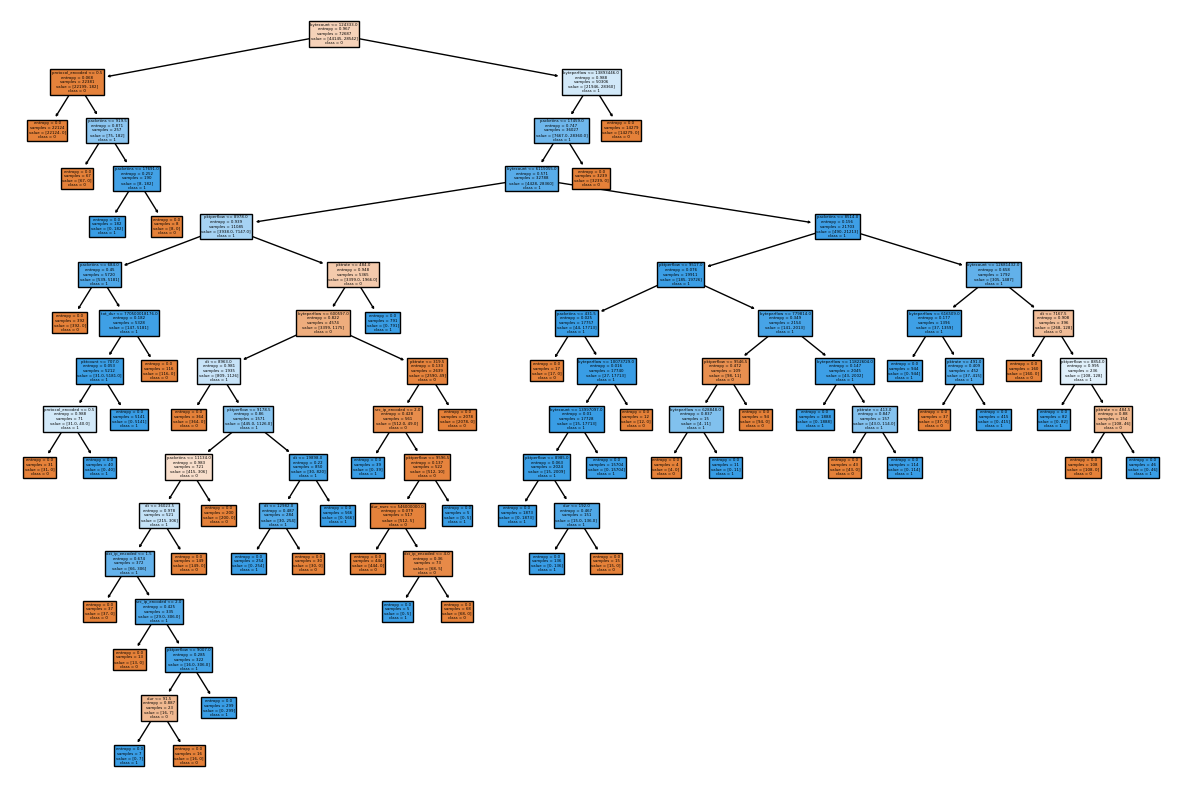

In [6]:
plt.figure(figsize=(15, 10))
tree.plot_tree(
    drzewo_data,
    max_depth=max_depth,
    class_names=['0', '1'],
    filled=True,
    feature_names=X_train.columns
)
plt.show()

Testowanie dokładności drzewa decyzyjnego

In [7]:
print(f"Dokładność na zbiorze uczącym: {drzewo.score(X_train,y_train)}")
print(f"Dokładność na zbiorze testowym: {drzewo.score(X_test,y_test)}")

Dokładność na zbiorze uczącym: 1.0
Dokładność na zbiorze testowym: 1.0


Ustalanie jak ważne są poszczególne cechy dla modelu

Które cechy?
Cecha 'dt' i jej istotność w drzewie: 0.015901552248877078
Cecha 'switch' i jej istotność w drzewie: 0.0
Cecha 'pktcount' i jej istotność w drzewie: 0.0028983012455524346
Cecha 'bytecount' i jej istotność w drzewie: 0.34981563040990565
Cecha 'dur' i jej istotność w drzewie: 0.0012937877854452156
Cecha 'dur_nsec' i jej istotność w drzewie: 0.00020410596577132085
Cecha 'tot_dur' i jej istotność w drzewie: 0.00991791082020868
Cecha 'flows' i jej istotność w drzewie: 0.0
Cecha 'packetins' i jej istotność w drzewie: 0.1572440744173243
Cecha 'pktperflow' i jej istotność w drzewie: 0.05429167425498183
Cecha 'byteperflow' i jej istotność w drzewie: 0.3569615535442876
Cecha 'pktrate' i jej istotność w drzewie: 0.02691449685312477
Cecha 'Pairflow' i jej istotność w drzewie: 0.0
Cecha 'port_no' i jej istotność w drzewie: 0.0
Cecha 'tx_bytes' i jej istotność w drzewie: 0.0
Cecha 'rx_bytes' i jej istotność w drzewie: 0.0
Cecha 'tx_kbps' i jej istotność w drzewie: 0.0
Cecha 'rx_kbps' i 

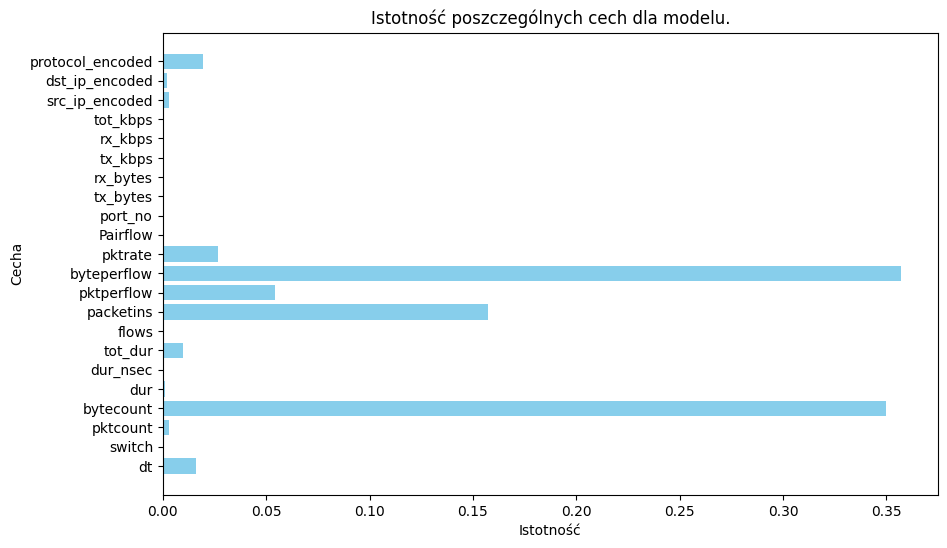

In [8]:
print("Które cechy?")
feature_importances = drzewo.feature_importances_
for i, feature_name in enumerate(X_train.columns):
    print(f"Cecha '{feature_name}' i jej istotność w drzewie: {feature_importances[i]}")
    
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importances, color='skyblue')
plt.xlabel('Istotność')
plt.ylabel('Cecha')
plt.title('Istotność poszczególnych cech dla modelu.')
plt.show()

Zależność głębokości drzewa decyzyjnego od dokładności modelu

In [9]:
criterion = 'entropy'
max_depth_values = range(1, 16)
min_samples_split_values = [2, 10, 20]
min_samples_leaf_values = [1, 5, 10]
max_features_values = [None, 'sqrt', 'log2']
max_leaf_nodes_values = [None, 10, 20]
min_impurity_decrease_values = [0.0, 0.01, 0.1]

results = []

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:
            for max_features in max_features_values:
                for max_leaf_nodes in max_leaf_nodes_values:
                    for min_impurity_decrease in min_impurity_decrease_values:
                        clf = tree.DecisionTreeClassifier(
                            criterion=criterion,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            max_features=max_features,
                            max_leaf_nodes=max_leaf_nodes,
                            min_impurity_decrease=min_impurity_decrease
                        )
                        clf.fit(X_train, y_train)
                        
                        y_train_pred = clf.predict(X_train)
                        y_test_pred = clf.predict(X_test)
                        
                        train_accuracy = accuracy_score(y_train, y_train_pred)
                        test_accuracy = accuracy_score(y_test, y_test_pred)
                        train_precision = precision_score(y_train, y_train_pred, average='weighted')
                        test_precision = precision_score(y_test, y_test_pred, average='weighted')
                        train_f1 = f1_score(y_train, y_train_pred, average='weighted')
                        test_f1 = f1_score(y_test, y_test_pred, average='weighted')
                        
                        results.append({
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'max_features': max_features,
                            'max_leaf_nodes': max_leaf_nodes,
                            'min_impurity_decrease': min_impurity_decrease,
                            'train_accuracy': train_accuracy,
                            'test_accuracy': test_accuracy,
                            'train_precision': train_precision,
                            'test_precision': test_precision,
                            'train_f1': train_f1,
                            'test_f1': test_f1
                        })

results_df = pd.DataFrame(results)

print(results_df)

best_result = results_df.loc[results_df['test_accuracy'].idxmax()]
print("\nBest hyperparameters for test accuracy:")
print(best_result)

c:\Users\PaceK\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PaceK\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PaceK\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

      max_depth  min_samples_split  min_samples_leaf max_features  \
0             1                  2                 1         None   
1             1                  2                 1         None   
2             1                  2                 1         None   
3             1                  2                 1         None   
4             1                  2                 1         None   
...         ...                ...               ...          ...   
3640         15                 20                10         log2   
3641         15                 20                10         log2   
3642         15                 20                10         log2   
3643         15                 20                10         log2   
3644         15                 20                10         log2   

      max_leaf_nodes  min_impurity_decrease  train_accuracy  test_accuracy  \
0                NaN                   0.00        0.695571       0.689330   
1              

Najlepsze hiperparametry

max_depth                  15

min_samples_split           2

min_samples_leaf            1

max_features             None

max_leaf_nodes            NaN

min_impurity_decrease     0.0

train_accuracy            1.0

test_accuracy             1.0

train_precision           1.0

test_precision            1.0

train_f1                  1.0

test_f1                   1.0
